In [1551]:
import matlab.engine
import numpy as np
import scipy.special as scp
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import copy as copy 
from scipy.linalg import block_diag
eng = matlab.engine.start_matlab()
from scipy.optimize import minimize

JacobiGL = lambda x, y, z: eng.JacobiGL(float(x), float(y), float(z), nargout=1)
JacobiGQ = lambda x, y, z: eng.JacobiGQ(float(x), float(y), float(z), nargout=2)

In [1552]:
def JacobiP(x, alpha, beta, n):
    P_n = np.zeros((n,x.shape[0]))
    P_n[0] = 1
    P_n[1] = 0.5*(alpha -beta + (alpha + beta + 2) * x)
    for i in range(1,n-1):
        an1n = 2*(i+alpha)*(i+beta)/((2*i+alpha+beta+1)*(2*i+alpha+beta))
        ann = (alpha**2 - beta**2)/((2*i+alpha+beta+2)*(2*i+alpha+beta))
        anp1n = 2*(i+1)*(i+alpha+beta+1)/((2*i+alpha+beta+2)*(2*i+alpha+beta+1))
        
        P_n[i+1] = ((ann+x) * P_n[i] - an1n*P_n[i-1])/anp1n
        #print(np.min(P_n[i]))
    return P_n

def JacobiP_n(x, alpha, beta, n):
    P_n = JacobiP(x, alpha, beta, n)
    if alpha ==1 and beta == 1:
        gamma = lambda alpha, beta, m: 2**(3)*(m+1)/(m+2)*1/((2*m+alpha+beta+1))
    elif alpha ==0 and beta == 0:
        gamma = lambda alpha, beta, m : 2/((2*m+alpha+beta+1))                           
    elif alpha == -1/2 and beta == - 1/2: 
        gamma = lambda alpha, beta, m : 2*scp.math.factorial(m)/((2*m+alpha+beta+1)*scp.gamma(m+1/2))

    for i in range(n):
        d = np.sqrt(gamma(alpha, beta, i))
        P_n[i] = P_n[i]/d
    
    return P_n

def GradJacobi_n(x, alpha, beta, n):
    P_diff = np.zeros((n,x.shape[0]))
    JacobiPnorma = JacobiP_n(x, alpha+1, beta+1, n)
    for i in range(1,n):
        P_diff[i] = JacobiPnorma[i-1] * np.sqrt(i*(i+alpha+beta+1))
    return P_diff

def vandermonde_calculator(n):
    x = np.array(list(itertools.chain(JacobiGL(0,0,n))))
    x = np.reshape(x,x.shape[0])
    return (JacobiP_n(x, 0, 0, n+1))

def vandermonde_dx(n):
    x = np.array(list(itertools.chain(JacobiGL(0,0,n))))
    x = np.reshape(x,x.shape[0])
    return (GradJacobi_n(x, 0, 0, n+1))

matrix_derivative_tt = lambda n : np.matmul(np.transpose(vandermonde_dx(n)), np.linalg.inv(np.transpose(vandermonde_calculator(n))))

mass_matrix = lambda n: np.dot(np.linalg.inv(vandermonde_calculator(n)),np.linalg.inv(np.transpose(vandermonde_calculator(n))))

In [1641]:
order = 80
length = 5
blocks = 0 #This is off by one. 

def initializer(order=4, length=2, blocks=5):

    D = matrix_derivative_tt(order-1) *(2/(length/(blocks+1))) #fixme
    M = mass_matrix(order-1)*(length/(2))*1/(blocks+1)

    x = np.array(list(itertools.chain(JacobiGL(0,0,order-1))))
    x = np.reshape(x,x.shape[0])
    x = (x+1)*(length/2)

    x = x/(blocks+1)

    D2w = np.dot(np.transpose(D), np.dot(M, D))
    Sx = np.dot(M,D)
    
    return x, M, D, Sx, D2w

x, M, D, Sx, D2w = initializer(order, length, blocks)
D2w[0] = 0 
D2w[-1] = 0
from scipy.linalg import block_diag
K = 1
r = 1
cmax = 1
alpha = 3
eps = 0.6
mu = 0.15
sigma_x = 1/np.sqrt(5)
c = np.zeros(order*(blocks+1))+1
BD = [M]*(blocks+1)
SD = [Sx]*(blocks+1)
DB = [D]*(blocks+1)

D0 = copy.deepcopy(D)
D0[0] = 0
D0[-1] = 0

M0 = copy.deepcopy(M)
M0[0] = 0
M0[-1] = 0


M_big = block_diag(*BD)
Sx_big = block_diag(*SD)
D_big = block_diag(*DB)


disc = 0.05

In [1554]:
np.dot(np.sin(x), np.dot(M,np.sin(x)))

2.6360052777223424

In [1480]:
np.dot(D_big, np.sin(x2))-np.cos(x2)

ValueError: shapes (80,80) and (120,) not aligned: 80 (dim 1) != 120 (dim 0)

In [1481]:
np.dot(np.sin(x), np.dot(D2w,np.sin(x)))

2.6352777968966095

In [1482]:
np.dot(np.cos(x), np.dot(Sx,np.sin(x)))

2.3639947222776567

In [1483]:
np.dot(D, np.cos(x))+np.sin(x)

array([-5.68434189e-14, -2.29116639e-13,  1.22847912e-13,  2.52887988e-14,
       -3.76573772e-14, -7.91033905e-14,  1.26842981e-14,  8.29891711e-14,
       -5.42066392e-14,  4.68791672e-14, -3.56659147e-14, -2.49800181e-15,
        1.88737914e-15,  8.32667268e-16,  1.62092562e-14, -1.97064587e-14,
       -3.49720253e-15,  1.54321000e-14, -1.34336986e-14,  1.57651669e-14,
       -1.09912079e-14,  9.99200722e-16, -5.99520433e-15, -1.19904087e-14,
       -1.66533454e-15,  3.66373598e-15,  6.88338275e-15, -3.44169138e-15,
       -7.77156117e-15, -1.39888101e-14, -1.54321000e-14,  8.88178420e-16,
        1.35447209e-14,  1.33226763e-15,  0.00000000e+00, -2.88657986e-15,
        2.99760217e-15,  1.21014310e-14, -1.05471187e-14,  3.66373598e-15,
       -1.11022302e-14, -1.66533454e-15,  2.05391260e-15,  1.08801856e-14,
       -3.74700271e-15, -9.46465128e-15, -8.97979607e-15,  2.96845881e-14,
       -1.04638520e-14, -2.39253062e-14,  1.14908083e-14, -1.88737914e-15,
        1.70974346e-14, -

In [1484]:
np.dot(np.cos(x2),np.dot(M_big, np.cos(x2)))

ValueError: shapes (80,80) and (120,) not aligned: 80 (dim 1) != 120 (dim 0)

In [1485]:
np.dot(M_big, ones)

ValueError: shapes (80,80) and (120,) not aligned: 80 (dim 1) != 120 (dim 0)

In [1642]:
def op_builder(blocks, order, length, base, c, disc = disc, M = M, D = D, D2w = D2w, Sx = Sx, r = r, K = K, Prey = True):
    
    Sx0 = copy.deepcopy(Sx)
    Sx0[0] = 0
    
    Sx0[-1] = 0
    if Prey is True: 
        operator_int = (r*x*(1-x/K) - x*c[0:order]).reshape(order,1) * Sx #\
#        - disc * M  #(2*x.reshape(order,1)*Sx0 + (x**2).reshape(order,1) * D2w) - disc * M #( ((2*x+x**2)).reshape(order,1) * D2w + 4*(x.reshape(order,1)*Sx)+2*M) - disc * M 
    else:
        operator_int = (((-(c[0:order])-mu)*x).reshape(order,1)) * Sx #\    
    
    operator_int = operator_int - 1/2*sigma_x**2 * ( ((x**2)).reshape(order,1) * D2w + 2*(x.reshape(order,1))*(2*Sx+Sx0)+2*M) 
    
    
    #- 1/2*sigma_x**2 * \
    #( ((x**2)).reshape(order,1) * D2w + (x.reshape(order,1))* \
    # (4*Sx)+2*M+2*x.reshape((order,1))*np.dot(np.transpose(D), M0)) - disc * M
    temp = np.zeros(order)
    temp[-2] = 1/2
    #print(operator_int[-1])
    if blocks > 0:
        operator_int[-1] = operator_int[-1] - temp #+ 1/2*sigma_x**2*(x[-1]**2*Sx[-1]+2*x[-1]*M[-1]) 
    else: 
        operator_int[-1] + 1/2*sigma_x**2*(x[-1]**2*Sx[-1]+2*x[-1]*M[-1])  #1/2*sigma_x**2*(x[-1]**2*Sx[-1]+2*x[-1]*M[-1]) 
    #print(operator_int[-1])
    if blocks > 0:
        zero_f = np.zeros((order,order-1))
        zero = np.zeros((order, order))
        parts = int_op_builder(blocks, order, length, x, c, disc, Prey = Prey)
        A = np.block([[operator_int, zero], [zero_f, parts[0]]])
        zero_mats = [0]*(blocks)
        zero_mats[0] = zero
        for i in range(1,blocks):
            zero_mats[i] = np.block([zero, zero_mats[i-1]])
        
        
        for i in range(1, len(parts)):
            A = np.block([[A, np.zeros((A.shape[0], order))], [zero_mats[i-1], zero_f, parts[i]]])
            A[(i+1)*order-1,(i+1)*order] = 1/2 #Central flux
        A[order-1,order] = 1/2
    else:
        A = operator_int
            
    return A

def int_op_builder(blocks, n, l, base, c, disc = disc, D = D, D2w = D2w, Sx = Sx, r = r, K = K, Prey = True):
    start_points = np.linspace(l/(blocks+1), l, blocks, endpoint = False)
    vec_shift = np.zeros(n+1)
    vec_shift[0] = 1/2
    vec_shift[2] = -1/2 #Central flux
    vec_2 = np.zeros(n+1)
    vec_2[-2] = 1/2
    list_of_blocs = []
    #print(op_temp.shape)
    Sx0 = copy.deepcopy(Sx)
    Sx0[0] = 0
    Sx0[-1] = 0
    for i in range(blocks):
        op_temp = np.zeros((n, n+1))
        x = start_points[i] + base
#        print(x*c[(i+1)*n:(i+2)*n])
        if Prey is True: 
            operator_int = (r*x*(1-x/K) - x*c[(i+1)*n:(i+2)*n]).reshape(order,1) * Sx #\
            #- 1/2*sigma_x**2*( (x**2).reshape(order,1) * D2w + 2*(x.reshape(order,1)*(Sx+Sx0))+2*M) - disc * M 
        else:
            operator_int = ((-(c[(i+1)*n:(i+2)*n]-mu)*x).reshape(order,1)) * Sx #\
            
        operator_int = operator_int - \
        1/2*sigma_x**2*( (x**2).reshape(order,1) * D2w + 2*(x.reshape(order,1)*(2*Sx+Sx0))+2*M) - disc * M 
        if i == blocks - 1:
            operator_int[-1] = operator_int[-1] + 1/2*sigma_x**2*(x[-1]**2*Sx[-1]+2*x[-1]*M[-1])
         #1/2*sigma_x**2 * ( ((x**2)).reshape(order,1) * D2w + (x.reshape(order,1))* \
         #(4*Sx)+2*M+2*x.reshape((order,1))*np.dot(np.transpose(D), M0)) - disc * M
         #   1/2*sigma_x**2*( (x**2).reshape(order,1) * D2w + 2*(x.reshape(order,1)*(2*Sx+Sx0))+2*M) - disc * M  
        #- 1/2*sigma_x**2 *(2*x.reshape(order,1)*Sx0 + (x**2).reshape(order,1) * D2w) - disc * M 
        ##+ #np.reshape(np.sqrt(c),(1,n)) * M
        #operator_int[0] = operator_int[0] + sigma_x**2*x[0]*Sx[0] #Added boundary term from integral in addition to upwind.. This seems wrong
        #operator_int[-1] = operator_int[-1] + sigma_x**2*x[-1]*Sx[-1]  #Final term is boundary term from integral... 
        op_temp[:,1:] = operator_int  
        op_temp[0] = vec_shift + op_temp[0]
        if i < blocks - 1:
            op_temp[-1] = op_temp[-1] - vec_2  
        list_of_blocs.append(op_temp)
    return list_of_blocs

In [1487]:
M.shape

(80, 80)

In [1488]:
A0[99]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [1534]:
c_opt = lambda V, op_params, h : np.dot(op_builder(*op_params, h, disc = 0), V)

In [1535]:
def c_fill_in(c_te, h, i):
    c_te[i] = h
    return c_te

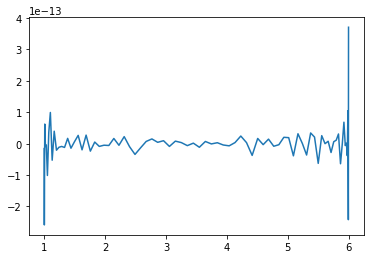

In [1536]:
plt.plot(x+1, np.dot(D,np.sin(x+1)) - np.cos(x+1))

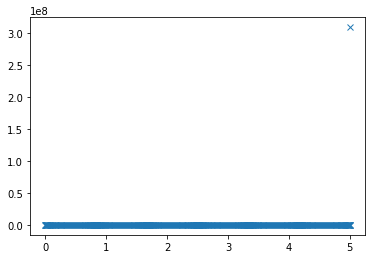

In [1537]:
plt.plot(x2, c_new, 'x')

In [1538]:
minimize(np.sin, [0], method = 'L-BFGS-B', bounds = [(0,None)])

      fun: array([0.])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
   status: 0
  success: True
        x: array([0.])

In [1539]:
#V_old = np.zeros(order*(blocks+1))
#err = 1
#iters = 5
#for k in range(100):
##for k in range(iters):
 #   V_old = V
#    c_old = copy.deepcopy(c_new)
#    for i in range(len(c_new)):
#        c_new[i] = minimize(lambda h :(-c_opt(V, op_params, c_fill_in(c_old, h, i))[i]-np.dot(np.sqrt(x2_r*c_fill_in(c_old, h, i).reshape((1, order*(blocks+1))))* M_big, ones))[i], 1/2*c_old[i], method = 'L-BFGS-B', bounds = [bnds]).x
#    A0 = op_builder(blocks, order, length, x, c_new)
#    V = np.linalg.solve(A0, -np.dot(np.sqrt(x2*c_new).reshape((order*(blocks+1),1))*M_big, ones))
#    err = np.dot(V-V_old, np.dot(M_big, V-V_old))
#    print(k/iters)

In [1643]:
op_params = [blocks, order, length, x]
x2 = 0
x2 = x
for i in range(blocks):
    x2 = np.concatenate([x2, (x+x2[-1])])
c_old = np.zeros(order*(blocks+1))
V = np.zeros(order*(blocks+1))
c_new = np.zeros(order*(blocks+1)) + 100000 #np.array(range(0,x2.shape[0])) #np.zeros(order*(blocks+1))+0.001
c_new[0] =0
x2_r = np.reshape(x2,(order*(blocks+1),1))
A0 = op_builder(blocks, order, length, x, c_new)
from scipy.optimize import basinhopping
bnds = ((0., None))
ones = np.zeros(order*(blocks+1))+1

In [1644]:
small =  order*(blocks+1)
big = small * 2 #np.int(small*1.5)

v_small = vandermonde_calculator(small - 1)
v_big = vandermonde_calculator(big - 1)
v_big_inv = np.linalg.inv(v_big)
v_small_inv = np.linalg.inv(v_small)

def aa_prod(f, g, v_small = v_small, v_small_inv = v_small_inv, v_big = v_big, v_big_inv = v_big_inv):
    n = f.shape[0]
    f_big = np.zeros(v_big.shape[0])
    g_big = np.zeros(v_big.shape[0])
    
    f_big[0:n] = (np.dot(v_small, f))
    g_big[0:n] = (np.dot(v_small, g))
    
    f_t = np.dot(v_big_inv, f_big)
    g_t = np.dot(v_big_inv, g_big)
    
    p_t = np.dot(v_big, f_t * g_t)
    print(p_t)
    #print(p_t)
    result = 1/2*np.dot(v_small_inv, p_t[0:n])

    
    return result

In [1604]:
def c_analytical_opt(V, M_big = M_big): #Shitty attempt at solving weak equation... Should have used functionals if I wanted to do this
    temp = (4*x*(np.dot(D,V))**2)
    temp[0] = 1
    temp = 1/temp
    temp[0] = 0
    temp[np.where(np.isnan(temp))] = 1
    temp[np.where(np.isinf(temp))] = 100000
    ones = np.zeros(M_big.shape[0]) + 1
    sol = 1/(np.dot(M_big,ones))*np.dot(M, temp)
    sol[sol<0] = 0
    return sol

In [1645]:
def c_analytical_opt_2(V, D_big = D_big, x2 = x2):
    temp = (4*x2*(np.dot(D_big,V))**2)
    temp[0] = 1
    temp = 1/temp
    temp[0] = 0
    temp[np.where(np.isnan(temp))] = 1
    temp[np.where(np.isinf(temp))] = 10
    return temp

In [1568]:
V_old = V
A0 = op_builder(blocks, order, length, x, c_new)
V = np.linalg.solve(A0, -np.dot(np.sqrt(x2*c_new).reshape((order*(blocks+1),1))*M_big, ones))
c_new = c_analytical_opt_2(V)
err = np.dot(c_new - c_old, np.dot(M_big, c_new - c_old)) #np.dot(V-V_old, np.dot(M_big, V-V_old))


In [1569]:
ones.shape

(480,)

In [1646]:
ones = np.zeros(order*(blocks+1))+1
V_old = np.zeros(order*(blocks+1))
err = 1
#for k in range(100):
counter = 0
while err>1.5*10**(-5):
    V_old = V
    A0 = op_builder(blocks, order, length, x, c_new)
    V = np.linalg.solve(A0, -np.dot(np.sqrt(x2*c_new).reshape((order*(blocks+1),1))*M_big, ones))
    c_new = c_analytical_opt_2(V)
    err = np.dot((V - V_old), np.dot(M_big, V - V_old)) #np.dot(V-V_old, np.dot(M_big, V-V_old))
    counter += 1
    if counter % 50 is 0:
        print(err)
        plt.plot(x2, V, 'x')

        plt.show()
V_x = V
c_x = c_new

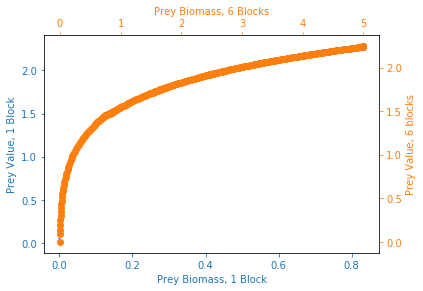

In [1624]:



fig=plt.figure()
ax=fig.add_subplot(111, label="1 Block")
ax2=fig.add_subplot(111, label="6 Blocks", frame_on=False)

ax.plot(x, V_1_prey_block_1, color="C0")
ax.set_xlabel("Prey Biomass, 1 Block", color="C0")
ax.set_ylabel("Prey Value, 1 Block", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.scatter(x2, V, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Prey Biomass, 6 Blocks', color="C1") 
ax2.set_ylabel('Prey Value, 6 blocks', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")


plt.savefig('1_block_6_block_compare_prey.png')


plt.show()

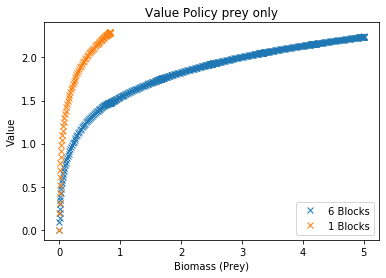

In [1582]:
fig = plt.figure()
plt.plot(x2, V, 'x' ,label = '6 Blocks')
plt.plot(x, V_1_prey_block_1, 'x' ,label = '1 Blocks')
plt.xlabel("Biomass (Prey)")
plt.ylabel("Value")
plt.title('Value Policy prey only')
plt.savefig('Prey' + str(blocks +1) + '_elem.png')
plt.legend(loc = 'lower right')

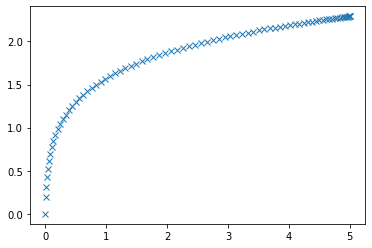

In [1546]:
plt.plot(x, V_1_prey_block_1, 'x')

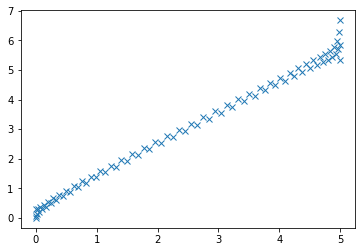

In [1548]:
plt.plot(x2, c_new, 'x')


In [1511]:
V_1_prey_block_1 = copy.deepcopy(V_x)

In [1647]:
op_params = [blocks, order, length, x]
x2 = 0
x2 = x
for i in range(blocks):
    x2 = np.concatenate([x2, (x+x2[-1])])
c_old = np.zeros(order*(blocks+1))
V = np.zeros(order*(blocks+1))
c_new = np.zeros(order*(blocks+1)) + 100000 #np.array(range(0,x2.shape[0])) #np.zeros(order*(blocks+1))+0.001
c_new[0] =0
x2_r = np.reshape(x2,(order*(blocks+1),1))
A0 = op_builder(blocks, order, length, x, c_new)
from scipy.optimize import basinhopping
bnds = ((0., None))
ones = np.zeros(order*(blocks+1))+1

In [1648]:
ones = np.zeros(order*(blocks+1))+1
V_old = np.zeros(order*(blocks+1))
err = 1
#for k in range(100):
counter = 0
while err>1.5*10**(-5):
    V_old = V
    A0 = op_builder(blocks, order, length, x, c_new, Prey = False)
    V = np.linalg.solve(A0, -np.dot(np.sqrt(x2*c_new).reshape((order*(blocks+1),1))*M_big, ones))
    c_new = c_analytical_opt_2(V)
    err = np.dot((V - V_old), np.dot(M_big, V - V_old)) #np.dot(V-V_old, np.dot(M_big, V-V_old))
    counter += 1
    if counter % 50 is 0:
        print(err)
        plt.plot(x2, V, 'x')

        plt.show()
V_y = V
c_y = c_new

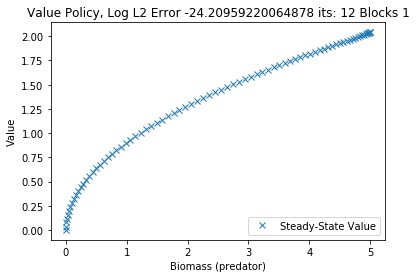

In [1649]:
fig = plt.figure()
plt.plot(x2, V, 'x' ,label = 'Steady-State Value')
plt.xlabel("Biomass (predator)")
plt.ylabel("Value")
plt.title('Value Policy, Log L2 Error '+ str(np.log(err)) + ' its: '+ str(counter) + ' Blocks ' + str(blocks + 1))
plt.savefig('Predator_' + str(blocks +1) + '_elem.png')

plt.legend(loc = 'lower right')

In [1600]:
V__PRED_1_BLOCK = copy.deepcopy(V_y)

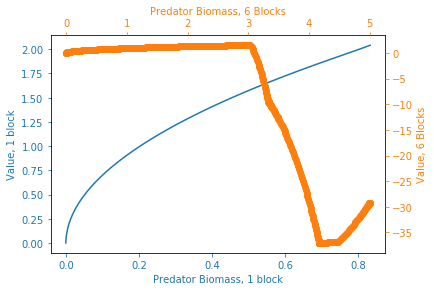

In [1620]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1 Block")
ax2=fig.add_subplot(111, label="6 Blocks", frame_on=False)

ax.plot(x, V__PRED_1_BLOCK, color="C0")
ax.set_xlabel("Predator Biomass, 1 block", color="C0")
ax.set_ylabel("Value, 1 block", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.scatter(x2, V, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Predator Biomass, 6 Blocks', color="C1") 
ax2.set_ylabel('Value, 6 Blocks', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")
plt.savefig('1_block_6_block_compare.png')

plt.show()

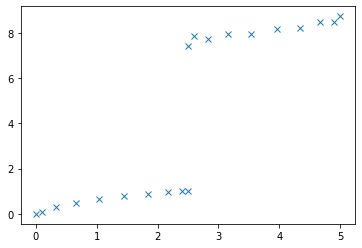

In [1640]:
V_2 = -V[x.shape[0]:]
plt.plot(x2, np.concatenate([V[0:x.shape[0]], V[x.shape[0]-1]+ V_2[::-1]]), 'x')

In [1532]:
V_t = np.linalg.solve(A0, -np.sqrt(np.dot((x2*c_new).reshape((order*(blocks+1),1))*M_big, ones)))
c_new_t = c_analytical_opt_2(V_t)


In [1575]:
V_t = np.linalg.solve(A0, -np.sqrt(np.dot((x2*c_new_t).reshape((order*(blocks+1),1))*M_big, ones)))
c_new_t = c_analytical_opt_2(V_t)
A0_t = op_builder(blocks, order, length, x, c_new_t)
A0[x.shape[0],x.shape[0]-1] = -1
#A0[2*x.shape[0]-1,-2] #= #A0[2*x.shape[0]-1,-2] + 1
A0_t[x.shape[0]:] = -A0_t[x.shape[0]:]


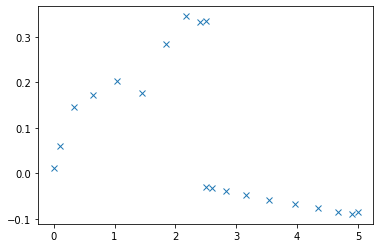

In [1576]:
plt.plot(x2, V_t, 'x')

In [1619]:
x

array([0.        , 0.10058261, 0.32653267, 0.65259381, 1.0434013 ,
       1.4565987 , 1.84740619, 2.17346733, 2.39941739, 2.5       ])

In [1618]:
np.dot(np.sin(x+1),np.dot(M, np.sin(x+1)))

1.3130777070267174

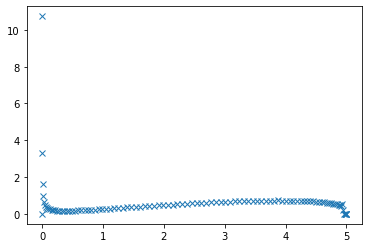

In [630]:
plt.plot(x2, c_new, 'x')

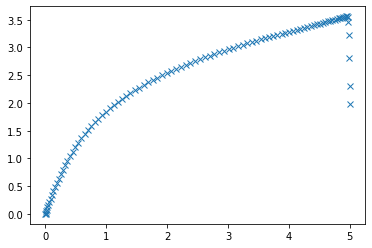

In [574]:
plt.plot(x, V, 'x')

[]

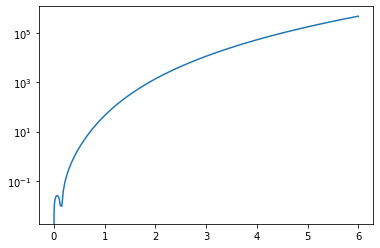

In [2367]:
plt.plot(x, np.abs(1/(np.dot(D, V)**2)*(x*c_new - x/(np.dot(D, V)**2) )))
plt.semilogy()

# This is where the 2 Dimensional fun starts. We only do a single element since the predator is unstable with the current numerical scheme. 

In [1650]:
K = 1
r = 1
cmax = 1
alpha = 3
eps = 0.6
mu = 0.15
big_ord = order**2
sigma_y = sigma_x

V = np.zeros(big_ord)
c_newx = np.zeros(big_ord) + 10 #np.array(range(0,x2.shape[0])) #np.zeros(order*(blocks+1))+0.001
c_newy = np.zeros(big_ord) + 10 #np.array(range(0,x2.shape[0])) #np.zeros(order*(blocks+1))+0.001

c_newy[0:order] = 0
c_newx[::order] = 0

ones = np.zeros(order)+1 
ones2 = np.kron(ones,ones)
I0 = np.identity(order)
I0[0] = 0
I0[-1] = 0

In [1262]:
x_ext.reshape((order, order))

ValueError: cannot reshape array of size 2500 into shape (80,80)

In [1651]:
V = V.reshape((order, order))
V[0] = V_x
V[:,0] = V_y
V = V.reshape(big_ord)

In [1264]:
np.where(V!=0)

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
          55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
          66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
          77,   78,   79,   80,  160,  240,  320,  400,  480,  560,  640,
         720,  800,  880,  960, 1040, 1120, 1200, 1280, 1360, 1440, 1520,
        1600, 1680, 1760, 1840, 1920, 2000, 2080, 2160, 2240, 2320, 2400,
        2480, 2560, 2640, 2720, 2800, 2880, 2960, 3040, 3120, 3200, 3280,
        3360, 3440, 3520, 3600, 3680, 3760, 3840, 3920, 4000, 4080, 4160,
        4240, 4320, 4400, 4480, 4560, 4640, 4720, 4800, 4880, 4960, 5040,
        5120, 5200, 5280, 5360, 5440, 

In [1265]:
ones2.shape

(6400,)

In [1266]:
BND_x = np.zeros((order, order))
BND_x[-1] = 1/2*sigma_x**2*(x[-1]**2*Sx[-1]+2*x[-1]*M[-1]) 
bnd_op_x = np.kron(BND_x, M)
bnd_op_y = np.kron(M, BND_x)

In [1652]:
y_ext = np.kron(x, ones)
x_ext = np.kron(ones, x)

In [1653]:
M2 = np.kron(M, M)
M20 = np.kron(M0, M0)
D0x = np.kron(D0, I0)
D0y = np.kron(I0, D0)
Dx = np.kron(D, np.identity(order))
Dy = np.kron(np.identity(order), D)
Sy2 = np.dot(M2, Dy)
Sx2 = np.dot(M2, Dx)
SSx2 = np.dot(Sx2, Dx)
SSy2 = np.dot(Sy2, Dy)
M2_side = np.zeros((big_ord, big_ord))
for i in range(order):
    M2_side[order-1 + i*order] = M2[order-1 + i*order] 
    M2_side[-order+1:] = M2[-order+1:]

In [1654]:
x_ext.shape

(6400,)

In [1655]:
Sx0_2 = np.dot(D0x, M2)
Sy0_2 = np.dot(D0y, M2)


In [1656]:
D2wx = np.dot(np.transpose(D0x),np.dot(M2, D0x))
D2wy = np.dot(np.transpose(D0y),np.dot(M2, D0y))

In [1657]:
x_react = (r*x_ext*(1-x_ext/K) - x_ext*y_ext*cmax*alpha/(alpha*x_ext + cmax)).reshape(big_ord,1)
y_react = (eps * x_ext*y_ext*cmax*alpha/(alpha*x_ext + cmax) - mu*y_ext).reshape(big_ord,1)

In [1658]:
diffu_x_2 = - 1/2*sigma_x**2 * ( ((x_ext**2)).reshape(big_ord,1) * D2wx + 2*(x_ext.reshape(big_ord,1))*(Sx2+Sx0_2)+2*M2)
diffu_y_2 = - 1/2*sigma_y**2 * ( ((y_ext**2)).reshape(big_ord,1) * D2wy + 2*(y_ext.reshape(big_ord,1))*(Sy2+Sy0_2)+2*M2)

In [1659]:
operator_const_old = x_react * Sx2 + y_react*Sy2 + diffu_x_2  + diffu_y_2 + bnd_op_x + bnd_op_y - disc*M2

In [1660]:
operator_const_new = x_react * Sx2 + y_react*Sy2 + 1/2*sigma_x**2*x_ext.reshape((big_ord,1))**2 * SSx2 + 1/2*sigma_y**2*y_ext.reshape((big_ord,1))*SSy2 - disc*M2

In [1661]:
corr_term_x = -sigma_x**2*(2*M2-4*x_ext.reshape((big_ord,1))*Sx2-(x_ext**2).reshape((big_ord, 1)) * SSy2)
corr_term_y = -sigma_y**2*(2*M2-4*y_ext.reshape((big_ord,1))*Sy2-(y_ext**2).reshape((big_ord, 1)) * SSx2)
diffu_x_w = -2*sigma_x**2*((x_ext**2).reshape((big_ord, 1))*D2wx + x_ext.reshape((big_ord, 1)) * M20)
diffu_y_w = -2*sigma_y**2*((y_ext**2).reshape((big_ord, 1))*D2wy + y_ext.reshape((big_ord, 1)) * M20)

In [1662]:
Bnd_op_W = (y_ext**2+x_ext**2).reshape((big_ord, 1)) * np.dot(np.dot(M2_side, Dy), Dy) + (y_ext**2+x_ext**2).reshape((big_ord, 1)) * np.dot(np.dot(M2_side, Dx), Dx) \
+ 2*(x_ext+y_ext).reshape((big_ord, 1))*M2_side 

In [1663]:
weak_op = x_react * Sx2 + y_react*Sy2 + 1/2*(corr_term_x + corr_term_y + diffu_x_w + diffu_y_w) + Bnd_op_W

In [1664]:
def new_op(c_valx, c_valy, operator_const = weak_op):
    #((c_val*x_ext).reshape((big_ord, 1)) * S2x + (c_val*y_ext).reshape((big_ord, 1))*S2y) 
    return operator_const - ((c_valx*x_ext).reshape((big_ord, 1)) * Sx2 + (c_valy*y_ext).reshape((big_ord, 1))*Sy2) 
def sol(c_valx, c_valy):
    x_c = np.sqrt(x_ext*c_valx)
    y_c = np.sqrt(y_ext*c_valy)
    return -np.dot((x_c + y_c).reshape((big_ord, 1)) * M2, ones2)

In [1154]:
D2wx[order]

array([0., 0., 0., ..., 0., 0., 0.])

In [1280]:
np.where((c_newx)>10)

(array([], dtype=int64),)

In [1281]:
np.where((c_newy)>10)

(array([], dtype=int64),)

In [1032]:
np.where(np.isinf(V))

(array([], dtype=int64),)

In [1665]:
def two_dim_opt_c(V):
    tempx = 4*x_ext*(np.dot(Dx, V))**2
    tempy = 4*y_ext*(np.dot(Dy, V))**2
    tempx[::order] = 1
    tempy[0:order] = 1
    tempx = 1/tempx
    tempy = 1/tempy
    tempx[::order] = 0
    tempy[0:order] = 0
    
    tempx[np.where(np.isnan(tempx))] = 1
    tempx[np.where(np.isinf(tempx))] = 10
    
    tempy[np.where(np.isnan(tempy))] = 1
    tempy[np.where(np.isinf(tempy))] = 10
    
    return tempx, tempy

In [1666]:
weak_sol_op_0 = block_diag(np.identity(2*order), np.zeros((order**2, order**2)))
for i in range(order):
    if i is 0:
        weak_sol_op_0[2*order, 0] = 1/4
        
        weak_sol_op_0[2*order, 2*order - 1] = 1/4
        
        
    else:   
        weak_sol_op_0[2*order+i, i] = 1/2
        weak_sol_op_0[(2*order)+order*i, 2*order-1+i] = 1/2

        internal_modifier = np.zeros((order**2, order**2))
for i in range(order):
    if i is 0:
        internal_modifier[i,i+order] = -1/4
        internal_modifier[i*order, i + 1] = -1/4 
    else: 
        internal_modifier[i,i+order] = -1/2
        internal_modifier[i*order, i + 1] = -1/2

In [1639]:
    op_A = new_op(c_newx, c_newy)
    sol_t = sol(c_newx, c_newy)
    weak_sol_op[2*order:, 2*order:] = weak_sol_op_0[2*order:, 2*order:] + (op_A+internal_modifier)
    big_sol_t[2*order:] = sol_t


In [1290]:
Dx.shape

(6400, 6400)

In [1640]:
V_plot = V[2*order:].reshape((order,order))
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.xlabel('Prey')
plt.ylabel('Pred')
ax.view_init(45, 30)
ax.plot_wireframe(X, Y, V_plot)
plt.show()

ValueError: cannot reshape array of size 6240 into shape (80,80)

In [1668]:
X, Y = np.meshgrid(x, x)
big_sol_t = np.zeros(order**2+2*order)
big_sol_t[0:order] = V_x
big_sol_t[order:2*order] = V_y
  
weak_sol_op = copy.deepcopy(weak_sol_op_0)
error = 10
err_latest = 100000
counter = 0
while error>10**(-6) and counter < 10:
    V_old = V  

    op_A = new_op(c_newx, c_newy)
    sol_t = sol(c_newx, c_newy)
    weak_sol_op[2*order:, 2*order:] = weak_sol_op_0[2*order:, 2*order:] + (op_A+internal_modifier)
    big_sol_t[2*order:] = sol_t
    V = np.linalg.solve(weak_sol_op, big_sol_t)
    c_newx, c_newy = two_dim_opt_c(V[2*order:])

    error = np.dot(V[2*order:] - V_old[2*order:], np.dot(M2, V[2*order:] - V_old[2*order:]))
    counter += 1
#    V[V<-0.1] = 0.01
#    print(error)
#    if counter % 2 == 0:
#        c_newx = c_newx_t
#    else:
#        c_newy = c_newy_t

    
    if counter % 50 is 0:
        if err>err_latest:
            break
        err_latest = error
        print(counter)
        print(error)
        V_plot = V[2*order:].reshape((order,order))
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        plt.xlabel('Prey')
        plt.ylabel('Pred')
        ax.view_init(45, 30)
        ax.plot_wireframe(X, Y, V_plot)
        plt.show()

/home/jaem/anaconda3/envs/advanced_num_diff/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


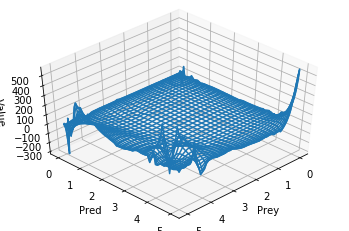

In [1672]:
V_plot = V[2*order:].reshape((order,order))
#V_plot = V_plot[0:30, 0:30]
X, Y = np.meshgrid(x, x)
fig = plt.figure()
plt.title('Problematic BVP')
ax = plt.axes(projection='3d')
plt.xlabel('Prey')
plt.ylabel('Pred')
ax.set_zlabel('Value')
ax.view_init(45, 45)
ax.plot_wireframe(X, Y, V_plot)
plt.savefig('Problems_with_corners.png')
plt.show()

In [997]:
np.where(V==V.min())

(array([100]),)

[]

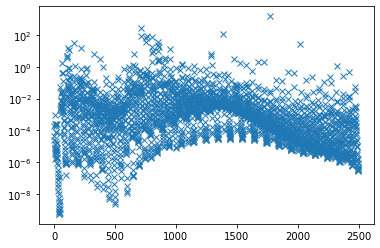

In [1098]:
plt.plot(c_newx, 'x')
plt.semilogy()

[]

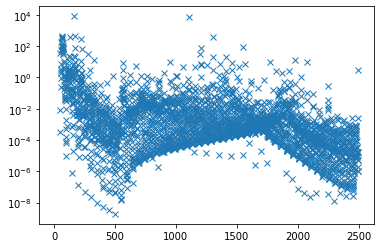

In [1099]:
plt.plot(c_newy, 'x')
plt.semilogy()

In [1094]:
M2_side[order-1]

array([ 1.49922228e-08, -3.72051826e-08,  4.98711929e-08, ...,
       -5.08889724e-10,  3.79644720e-10,  1.49922228e-08])

In [1083]:
V[2*order]

3.6110380192931366

In [1084]:
c_newx[0]

0.0

In [1085]:
c_newy[0]

0.0

In [1086]:
big_sol_t[100]

-0.0

In [1087]:
V[2*order::order] - V_y

array([  3.61180138,  -1.44919089,  -2.91920256,  10.7864431 ,
        34.66983588, -16.82938904, -13.85993239,  33.79699461,
        12.19516808,  -6.43389322,  62.70295263,  27.00341606,
       -20.69746064,   0.59897578,   3.62479155,   2.62429465,
         2.62772995,  -1.57602734,  -4.17000628,  -0.53876756,
         3.66137857,   3.94582449,   5.31197239,   5.09836321,
         5.799527  ,   6.15833341,   7.4036121 ,   8.14418094,
         9.76684046,  10.94309916,  13.14210431,  15.05692395,
        18.22842529,  21.36253922,  26.01316161,  31.02109183,
        37.90201476,  45.8307446 ,  56.26047601,  67.9623333 ,
        82.48358234,  98.0287708 , 115.05306544, 130.65120102,
       145.88792386, 158.23142866, 172.45841435, 193.5846491 ,
       213.9273456 , 197.66009433])

In [1088]:
V[2*order:3*order] - V_x

array([ 3.62028348e+00,  2.45992337e+00,  2.70185294e+00,  2.09187370e+00,
        2.29308376e+00,  1.66005865e+00,  1.94918821e+00,  1.40504879e+00,
        1.33358757e+00,  1.09585011e+00,  1.61519747e+00, -7.10632003e-01,
        7.55283337e-01,  6.74283014e-01,  4.05175450e-01,  3.61641568e-01,
        7.92788429e-02, -2.67012420e-03,  1.45650230e-01,  8.54464326e-01,
        2.46117918e-01,  2.75100351e-01, -5.93450353e-02, -1.72614146e-01,
       -2.31238408e-01, -2.08335139e-01, -2.19722076e-01, -1.66243427e-01,
       -1.62005965e-01, -7.62819883e-02, -4.47688889e-02,  8.33598037e-02,
        1.52202822e-01,  3.27234905e-01,  4.26928624e-01,  6.19880928e-01,
        6.64038586e-01,  7.13252170e-01,  4.19495305e-01, -1.15260456e-01,
       -1.36870277e+00, -3.20295681e+00, -5.98981636e+00, -8.99745222e+00,
       -1.17300420e+01, -1.20504717e+01, -8.68172736e+00, -1.20380836e+00,
        3.49528714e+00, -2.21989912e+00])

In [1061]:
np.where(weak_sol_op_0[100] == -0.25)

(array([150]),)

In [1057]:
np.where(weak_sol_op[100] == 0.25)

(array([ 0, 49]),)

In [525]:
weak_sol_op = copy.deepcopy(weak_sol_op_0)
weak_sol_op[2*order:, 2*order:] = weak_sol_op_0[2*order:, 2*order:] + op_A

In [627]:
weak_sol_op_0

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [725]:
internal_modifier[i]

array([0., 0., 0., ..., 0., 0., 0.])

In [675]:
A = np.zeros(weak_sol_op_0.shape[0])
A[15] = 1

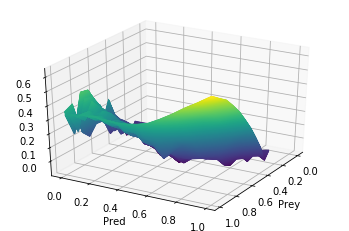

In [512]:
X, Y = np.meshgrid(x[0:20], x[0:20])
V_plot = V.reshape((order,order))
V_plot = V_plot[0:20, 0:20]
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.xlabel('Prey')
plt.ylabel('Pred')
ax.view_init(30, 30)
#ax.plot_wireframe(X, Y, V_plot)
ax.contour3D(Y, X, V_plot, 500)

In [676]:
np.dot(weak_sol_op_0, A)

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  , -0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

In [231]:
V[0::order]

array([-6.39595767e-06,  3.54016410e-02,  8.18916649e-02,  1.24997778e-01,
        1.68158279e-01,  2.10665740e-01,  2.53110539e-01,  2.95233650e-01,
        3.37245334e-01,  3.79012055e-01,  4.20629991e-01,  4.62016154e-01,
        5.03219458e-01,  5.44181706e-01,  5.84928374e-01,  6.25415073e-01,
        6.65654239e-01,  7.05609909e-01,  7.45286676e-01,  7.84654089e-01,
        8.23711756e-01,  8.62433048e-01,  9.00814280e-01,  9.38831604e-01,
        9.76479109e-01,  1.01373506e+00,  1.05059202e+00,  1.08702992e+00,
        1.12304029e+00,  1.15860443e+00,  1.19371316e+00,  1.22834894e+00,
        1.26250215e+00,  1.29615625e+00,  1.32930136e+00,  1.36192187e+00,
        1.39400776e+00,  1.42554425e+00,  1.45652134e+00,  1.48692503e+00,
        1.51674542e+00,  1.54596925e+00,  1.57458682e+00,  1.60258561e+00,
        1.62995623e+00,  1.65668694e+00,  1.68276876e+00,  1.70819084e+00,
        1.73294483e+00,  1.75702097e+00,  1.78041183e+00,  1.80310904e+00,
        1.82510653e+00,  

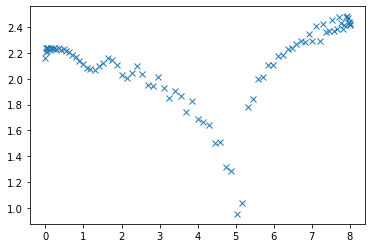

In [88]:
#plt.plot(x, V[order:2*order])
plt.plot(x, V[50*order:51*order], 'x')

In [85]:
V[3*order:4*order]

array([0.14876829, 5.3153426 , 2.91540418, 4.20476527, 0.04998967,
       2.02078028, 0.16502121, 1.62373519, 0.23850711, 1.4120604 ,
       0.31839354, 1.2991354 , 0.41009899, 1.2706273 , 0.54571544,
       1.33108255, 0.74531037, 1.49386272, 1.03241839, 1.7570972 ,
       1.38136983, 2.05033594, 1.6732549 , 2.1931779 , 1.71351352,
       2.06791947, 1.57604046, 1.99907161, 1.7303808 , 2.25463427,
       1.90730184, 2.16537789, 1.7797209 , 2.26770398, 2.02743297,
       2.23842924, 1.90416101, 2.40593688, 2.03357636, 2.26631577,
       2.15889445, 2.3566558 , 2.0656791 , 2.51183203, 2.0375359 ,
       2.53955986, 2.10886691, 2.51546334, 2.19373238, 2.4930006 ,
       2.25584558, 2.4965299 , 2.2968309 , 2.50976332, 2.3229976 ,
       2.53304933, 2.33929491, 2.56191797, 2.34837279, 2.59491873,
       2.34684999, 2.63457313, 2.33619156, 2.68163323, 2.31886802,
       2.72144634, 2.31916857, 2.71808562, 2.38779484, 2.6316065 ,
       2.50536239, 2.59542601, 2.43253388, 2.77604448, 2.35728

[]

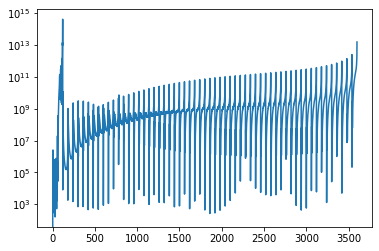

In [798]:
plt.plot(c_new)
plt.semilogy()

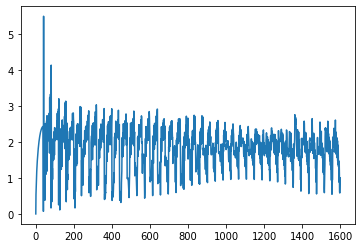

In [755]:
plt.plot(V)

In [715]:
counter

5